### Generate synthetic survival data

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import integrate
from sklearn.metrics import mean_absolute_error

np.random.seed(0)

device = 'cpu'

n_samples = 5000
error = 0.2

n_hidden = 32
learning_rate = 5e-4

# Define feature functions
def feature_1(x):
    return np.sin(3 * np.pi * x)

def feature_2(x):
    return (np.cos(2.6*2 * np.pi * x) + 0.5 * x) * (x-0.5)**2

def feature_3(x):
    return np.piecewise(x, [x < 0.1, (x >= 0.1) & (x < .275), (x >= 0.275) & (x < 0.6), (x >= 0.6) & (x < 0.75), x >= 0.75],
                        [lambda x: -3/2 * x + 0.5,
                         lambda x: 2 * x, 
                         lambda x: np.sin(3 * np.pi * x), 
                         lambda x: 2 * x**2 - 1,
                         lambda x: np.cos(2.3 * np.pi * x) + 0.5 * x])

def feature_4(x):
    return np.piecewise(x, [x<0.6, x>=0.6], 
                        [lambda x: x, 
                         lambda x: -(x**5) + x + (0.6)**5])

# Normalize the functions to be centered around 0 and all vals in [-1, 1]
def normalize_shape_function(shape_func, num_points=10000):
    
    # Numerical integration from 0 to 1
    x = np.linspace(0, 1, num_points)
    y = shape_func(x)
    avg_value = integrate.simpson(y, x=x)

    # Shift to center on 0
    y_shifted = y - avg_value
    
    # Scale the function
    scale_factor = 1 / np.mean(np.abs(y_shifted))
    y_scaled = y_shifted * scale_factor
    
    # Rescale so all values are within [-1, 1]
    max_abs_val = np.max(np.abs(y_scaled))
    final_scale = 1 / max_abs_val
    
    # Create the normalized shape function
    def normalized_func(x):
        return (shape_func(x) - avg_value) * scale_factor * final_scale
    
    return normalized_func

feat_lst = [feature_1, feature_2, feature_3, feature_4]
feat_lst = [normalize_shape_function(feat) for feat in feat_lst]
n_features = len(feat_lst)


# Generate synthetic data

# Initialize feature matrix
X = np.zeros((n_samples, n_features + 1))

# Generate features for each observation that are independent and uniformly distributed
for i in range(n_features):
    X[:, i] = np.random.uniform(0, 1, n_samples)

# Calculate sum of features (this represents risk score)
X[:, n_features] = sum(feat_lst[i](X[:, i]) for i in range(n_features)) + np.random.normal(0, error, n_samples)

# Create DataFrame
data = pd.DataFrame(X, columns=[f'Feature {i}' for i in range(1, n_features + 1)] + ['Risk'])

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Define observation times
t = 100
t_max = 1000
data["p"] = data["Risk"].apply(sigmoid)
# Draw Bernoulli RV X ~ Bernoulli(p)
data["Event"] = np.random.binomial(1, data["p"]).astype(bool)

def generate_death_times(event, t, t_max):
    if event:
        return np.random.uniform(0, t)
    else:
        return np.random.uniform(t, t_max)

data["Time"] = data.apply(lambda row: generate_death_times(row["Event"], t, t_max), axis=1)

X = data.drop(["Risk", "p", "Time", "Event"], axis=1)
y = np.array(list(zip(data["Event"], data["Time"])), dtype=[('event', 'bool'), ('time', 'float32')])

data

,Feature 1,Feature 2,Feature 3,Feature 4,Risk,p,Event,Time
0,0.548814,0.366780,0.748268,0.386138,-1.041074,0.260943,False,398.098166
1,0.715189,0.297624,0.180203,0.712477,0.886342,0.708135,True,49.817181
2,0.602763,0.068600,0.389023,0.580985,-0.399390,0.401459,True,22.315682
3,0.544883,0.352528,0.037600,0.463138,-0.335100,0.417000,True,85.918504
4,0.423655,0.232196,0.011788,0.943646,-1.117026,0.246563,True,40.370965
...,...,...,...,...,...,...,...,...
4995,0.218156,0.550447,0.334282,0.748175,0.470750,0.615561,True,91.900812
4996,0.235453,0.397151,0.195498,0.298267,0.491503,0.620460,True,70.196360
4997,0.197388,0.758430,0.532430,0.446456,0.091582,0.522879,True,22.321190
4998,0.398687,0.023787,0.374117,0.360127,-0.400862,0.401105,True,9.264020


### Train models

In [142]:
import sys 
sys.path.append("../models")
from dnamite import DNAMiteSurvival

dnamite = DNAMiteSurvival(
    n_features=n_features,
    n_embed=n_hidden,
    n_hidden=n_hidden,
    device=device,
    kernel_size=10,
    kernel_weight=5,
    learning_rate=learning_rate,
    n_output=1
)
y = np.array(list(zip(data["Event"], data["Time"])), dtype=[('event', 'bool'), ('time', 'float32')])
dnamite.fit(X, y)

SPlIT 0


  0%|          | 0/32 [00:00<?, ?it/s]

Early stopping: Test loss has not improved for 5 consecutive epochs.


Early stopping: Test loss has not improved for 5 consecutive epochs.
SPlIT 1


Early stopping: Test loss has not improved for 5 consecutive epochs.


Early stopping: Test loss has not improved for 5 consecutive epochs.
SPlIT 2


Early stopping: Test loss has not improved for 5 consecutive epochs.


Early stopping: Test loss has not improved for 5 consecutive epochs.
SPlIT 3


Early stopping: Test loss has not improved for 5 consecutive epochs.


Early stopping: Test loss has not improved for 5 consecutive epochs.
SPlIT 4


Early stopping: Test loss has not improved for 5 consecutive epochs.


Early stopping: Test loss has not improved for 5 consecutive epochs.


In [143]:
from nam import NAMSurvival

nam = NAMSurvival(
    n_features=n_features,
    n_hidden=n_hidden,
    device=device,
    learning_rate=1e-3,
    n_output=1
)
nam.fit(X, y)

SPlIT 0


  0%|          | 0/32 [00:00<?, ?it/s]

Early stopping at 51 epochs: Test loss has not improved for 5 consecutive epochs.


Early stopping at 18 epochs: Test loss has not improved for 5 consecutive epochs.
SPlIT 1


Early stopping at 49 epochs: Test loss has not improved for 5 consecutive epochs.


Early stopping at 39 epochs: Test loss has not improved for 5 consecutive epochs.
SPlIT 2


Early stopping at 25 epochs: Test loss has not improved for 5 consecutive epochs.


Early stopping at 10 epochs: Test loss has not improved for 5 consecutive epochs.
SPlIT 3


Early stopping at 18 epochs: Test loss has not improved for 5 consecutive epochs.


Early stopping at 16 epochs: Test loss has not improved for 5 consecutive epochs.
SPlIT 4


Early stopping at 37 epochs: Test loss has not improved for 5 consecutive epochs.


Early stopping at 38 epochs: Test loss has not improved for 5 consecutive epochs.


In [145]:
# DNAMite w/out kernel
dnamite_kw0 = DNAMiteSurvival(
    n_features=n_features,
    n_embed=n_hidden,
    n_hidden=n_hidden,
    device=device,
    kernel_size=0,
    kernel_weight=0.0,
    learning_rate=learning_rate,
    n_output=1
)
dnamite_kw0.fit(X, y)

SPlIT 0


  0%|          | 0/32 [00:00<?, ?it/s]

Early stopping: Test loss has not improved for 5 consecutive epochs.


Early stopping: Test loss has not improved for 5 consecutive epochs.
SPlIT 1


Early stopping: Test loss has not improved for 5 consecutive epochs.


Early stopping: Test loss has not improved for 5 consecutive epochs.
SPlIT 2


Early stopping: Test loss has not improved for 5 consecutive epochs.


Early stopping: Test loss has not improved for 5 consecutive epochs.
SPlIT 3


Early stopping: Test loss has not improved for 5 consecutive epochs.


Early stopping: Test loss has not improved for 5 consecutive epochs.
SPlIT 4


Early stopping: Test loss has not improved for 5 consecutive epochs.


Early stopping: Test loss has not improved for 5 consecutive epochs.


In [146]:
# NAM w/ ExU
nam_exu = NAMSurvival(
    n_features=n_features,
    n_hidden=n_hidden,
    device=device,
    learning_rate=1e-3,
    n_output=1,
    exu=True
)
nam_exu.fit(X, y)

SPlIT 0


  0%|          | 0/32 [00:00<?, ?it/s]

Early stopping at 53 epochs: Test loss has not improved for 5 consecutive epochs.


SPlIT 1


Early stopping at 26 epochs: Test loss has not improved for 5 consecutive epochs.


SPlIT 2


Early stopping at 26 epochs: Test loss has not improved for 5 consecutive epochs.


SPlIT 3


Early stopping at 59 epochs: Test loss has not improved for 5 consecutive epochs.


SPlIT 4


Early stopping at 22 epochs: Test loss has not improved for 5 consecutive epochs.


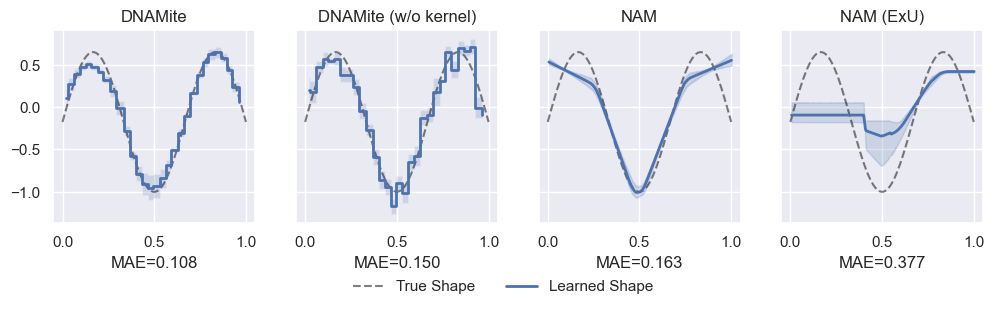

In [147]:
from datetime import datetime

feature_num = 1
true_feature = feat_lst[feature_num-1]

fig, axes = plt.subplots(1, 4, figsize=(12, 2.5), sharey=True, sharex=True)

model_names = ['DNAMite', 'DNAMite (w/o kernel)', 'NAM', 'NAM (ExU)']
mae_dict = {modelname: [] for modelname in model_names}

eval_time_dnamite = dnamite.eval_times[0].numpy().flatten()[0]
eval_time_nam = nam.eval_times[0].numpy().flatten()[0]

for ax, model in zip(axes, [dnamite, dnamite_kw0, nam, nam_exu]):

    model_name = 'NAM' if model == nam else 'NAM (ExU)' if model == nam_exu else 'DNAMite' if model == dnamite else 'DNAMite (w/o kernel)'
        
    # Plot the true feature shape
    x = np.linspace(0, 1, 100)
    y_true = true_feature(x)
    ax.plot(x, y_true, color='black', linestyle='--', alpha=0.5, label='True Shape')

    if model_name == 'NAM' or model_name == 'NAM (ExU)':
        sd = np.sqrt(1/12)
        shape_data = model.get_shape_function(f"Feature {feature_num}", X, eval_time=eval_time_nam, feat_min=0, feat_max=1)
        shape_data["input"] = (shape_data["input"] * sd + 0.5)
        sns.lineplot(data=shape_data, x="input", y="shape", ax=ax, linewidth=2, label='Learned Shape', legend=False)

        # Calculate MAE for the NAM
        y_true = true_feature(np.asarray(shape_data["input"].apply(lambda x: 0 if x < 0 else x)))
        mae = mean_absolute_error(y_true, shape_data["shape"])
        mae_dict[model_name].append(mae)

    else:
        shape_data = model.get_shape_function(f"Feature {feature_num}", eval_time=eval_time_dnamite)
        non_missing = shape_data[shape_data["bin"].notna()]
        grouped = non_missing.groupby("bin")["score"].agg(['mean', 'sem']).reset_index().sort_values('bin')

        ax.plot(grouped['bin'], grouped['mean'], drawstyle='steps-post', linewidth=2, label='Learned Shape')

        # Fill error bars
        ax.fill_between(grouped['bin'], 
                        grouped['mean'] - 1.96 * grouped['sem'], 
                        grouped['mean'] + 1.96 * grouped['sem'], 
                        alpha=0.2,
                        step='post')

        # Calculate MAE for DNAMite
        bin_centers = grouped['bin']
        y_true_dnamite = true_feature(np.asarray(bin_centers))
        mae_dnamite = mean_absolute_error(y_true_dnamite, grouped['mean'])
        mae_dict[model_name].append(mae_dnamite)

    ax.set_title(model_name)
    ax.set_xlabel(f"MAE={mae_dict[model_name][0]:.3f}")

# Add a legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -.23), ncol=4, frameon=False)

# Save the figure
now = datetime.now()
now = now.strftime("%m%d%H%M")
plt.savefig(f"figures/feature{feature_num}_{now}.pdf", bbox_inches='tight')
plt.show()

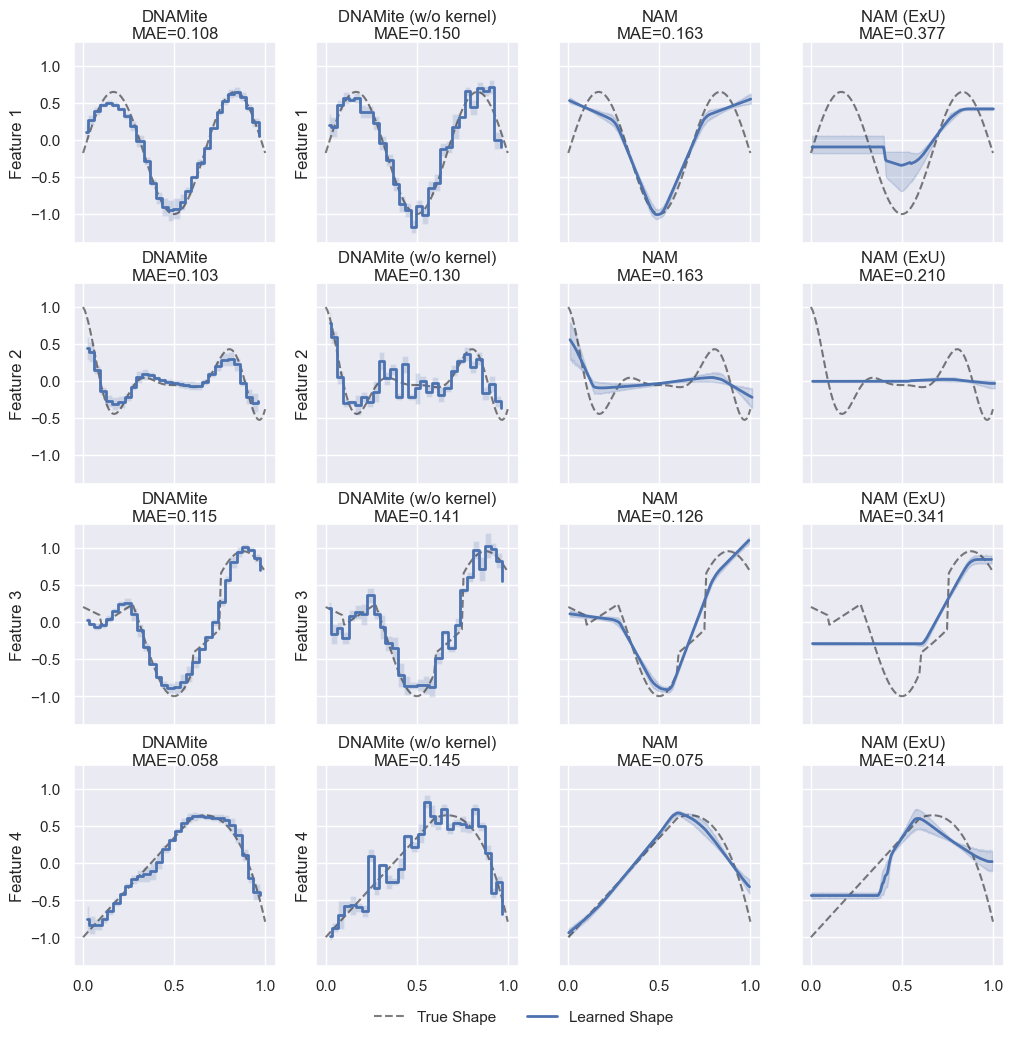

In [148]:
# generate plot with all features
# 4x4 grid
fig, axes = plt.subplots(4, 4, figsize=(12, 12), sharey=True, sharex=True)

model_names = ['DNAMite', 'DNAMite (w/o kernel)', 'NAM', 'NAM (ExU)']
mae_dict = {modelname: [] for modelname in model_names}

for feature_num in range(1, n_features + 1):
    true_feature = feat_lst[feature_num-1]

    for ax, model in zip(axes[feature_num-1], [dnamite, dnamite_kw0, nam, nam_exu]):

        model_name = 'NAM' if model == nam else 'NAM (ExU)' if model == nam_exu else 'DNAMite' if model == dnamite else 'DNAMite (w/o kernel)'
            
        # Plot the true feature shape
        x = np.linspace(0, 1, 100)
        y_true = true_feature(x)
        ax.plot(x, y_true, color='black', linestyle='--', alpha=0.5, label='True Shape')

        if model_name == 'NAM' or model_name == 'NAM (ExU)':
            sd = np.sqrt(1/12)
            shape_data = model.get_shape_function(f"Feature {feature_num}", X, eval_time=eval_time_nam, feat_min=0, feat_max=1)
            shape_data["input"] = (shape_data["input"] * sd + 0.5)
            sns.lineplot(data=shape_data, x="input", y="shape", ax=ax, linewidth=2, label='Learned Shape', legend=False)

            # Calculate MAE for the model
            y_true = true_feature(np.asarray(shape_data["input"].apply(lambda x: 0 if x < 0 else x)))
            mae = mean_absolute_error(y_true, shape_data["shape"])
            mae_dict[model_name].append(mae)

        else:
            shape_data = model.get_shape_function(f"Feature {feature_num}", eval_time=eval_time_dnamite)
            non_missing = shape_data[shape_data["bin"].notna()]
            grouped = non_missing.groupby("bin")["score"].agg(['mean', 'sem']).reset_index().sort_values('bin')

            ax.plot(grouped['bin'], grouped['mean'], drawstyle='steps-post', linewidth=2, label='Learned Shape')

            # Fill error bars
            ax.fill_between(grouped['bin'], 
                            grouped['mean'] - 1.96 * grouped['sem'], 
                            grouped['mean'] + 1.96 * grouped['sem'], 
                            alpha=0.2,
                            step='post')

            # Calculate MAE for DNAMite
            bin_centers = grouped['bin']
            y_true_dnamite = true_feature(np.asarray(bin_centers))
            mae_dnamite = mean_absolute_error(y_true_dnamite, grouped['mean'])
            mae_dict[model_name].append(mae_dnamite)

        ax.set_title(f"{model_name}\nMAE={mae_dict[model_name][feature_num-1]:.3f}", pad=0)
        ax.set_xlabel(None)
        ax.set_ylabel(f"Feature {feature_num}")

# Add a legend
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.05), ncol=4, frameon=False)

# Save the figure
now = datetime.now()
now = now.strftime("%m%d%H%M")
plt.savefig(f"figures/all_features_{now}.pdf", bbox_inches='tight')

plt.show()

### Compare predictive performance with & without smoothing

In [1]:
def feature_1(x):
    return np.piecewise(x, [x < 0.5, x >= 0.5],
                        [lambda x: 4 * (x - 0.25) ** 2, 
                         lambda x: 4 * (x - 0.75)**2])

def feature_2(x):
    return np.sin(3 * np.pi * x)/2

def feature_3(x):
    return np.cos(2.3 * np.pi * x) + 0.5 * x

def feature_4(x):
    return np.piecewise(x, [x < 0.33, (x >= 0.33) & (x < 0.66), x >= 0.66],
                        [lambda x: 3 * x, 
                         lambda x: np.sin(3 * np.pi * x), 
                         lambda x: 2 * x**2 - 1])

def feature_5(x):
    return np.piecewise(x, [x < 0.1, (x >= 0.1) & (x < .275), (x >= 0.275) & (x < 0.6), (x >= 0.6) & (x < 0.75), x >= 0.75],
                        [lambda x: -3/2 * x + 1,
                         lambda x: 2 * x, 
                         lambda x: np.sin(3 * np.pi * x), 
                         lambda x: 2 * x**2 - 1,
                         lambda x: np.cos(2.3 * np.pi * x) + 0.5 * x])

def feature_6(x):
    return (x-0.5)**2

def feature_7(x):
    return np.piecewise(x, [x<0.6, x>=0.6], [lambda x: 2*x, lambda x: -2*x**5 + 2*x + 2*(0.6)**5])

In [6]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

np.random.seed(1)

feat_lst = [feature_1, feature_2, feature_3, feature_4, feature_5, feature_6, feature_7]

n_samples = 100000
train_size = 20000
n_features = len(feat_lst)
error = .1

learning_rate=5e-4

# Initialize feature matrix
X_new = np.zeros((n_samples, n_features + 1))

for i in range(n_features):
    X_new[:, i] = np.random.uniform(0, 1, n_samples)

# Calculate sum of risks
X_new[:, n_features] = sum(feat_lst[i](X_new[:, i]) for i in range(n_features)) + np.random.normal(0, error, n_samples)

# Create DataFrame
data_new = pd.DataFrame(X_new, columns=[f'Feature {i}' for i in range(1, n_features + 1)] + ['Risk'])

data_new["p"] = data_new["Risk"].apply(sigmoid)
# Draw Bernoulli RV X ~ Bernoulli(p)
data_new["Event"] = np.random.binomial(1, data_new["p"]).astype(bool)

data_new["Time"] = data_new.apply(lambda row: generate_death_times(row["Event"], t, t_max), axis=1)

X_new = data_new.drop(["Risk", "p", "Time", "Event"], axis=1)
y_new = np.array(list(zip(data_new["Event"], data_new["Time"])), dtype=[('event', 'bool'), ('time', 'float32')])

# Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, train_size=train_size)

from models.dnamite import DNAMiteSurvival
dnamite2 = DNAMiteSurvival(
    n_features=n_features,
    n_embed=n_hidden,
    n_hidden=n_hidden,
    device=device,
    kernel_size=6,
    kernel_weight=2.5,
    learning_rate=learning_rate,
    n_output=1
)
dnamite2.fit(X_train, y_train)

dnamite_kw02 = DNAMiteSurvival(
    n_features=n_features,
    n_embed=n_hidden,
    n_hidden=n_hidden,
    device=device,
    kernel_size=0,
    kernel_weight=0.0,
    learning_rate=learning_rate,
    n_output=1
)
dnamite_kw02.fit(X_train, y_train)

# Calculate AUC for DNAMite and DNAMite (w/o kernel)
# Train data
y_pred_dnamite_train = dnamite2.predict(X_train)
y_pred_dnamite_kw0_train = dnamite_kw02.predict(X_train)

auc_dnamite_train = roc_auc_score(y_train["event"], y_pred_dnamite_train)
auc_dnamite_kw0_train = roc_auc_score(y_train["event"], y_pred_dnamite_kw0_train)

print(f"AUC for DNAMite on training data: {auc_dnamite_train:.5f}")
print(f"AUC for DNAMite (w/o kernel) on training data: {auc_dnamite_kw0_train:.5f}")
print(f"AUC difference on training data: {auc_dnamite_train - auc_dnamite_kw0_train:.5f}")

# Test data
y_pred_dnamite_test = dnamite2.predict(X_test)
y_pred_dnamite_kw0_test = dnamite_kw02.predict(X_test)

auc_dnamite_test = roc_auc_score(y_test["event"], y_pred_dnamite_test)
auc_dnamite_kw0_test = roc_auc_score(y_test["event"], y_pred_dnamite_kw0_test)

print(f"AUC for DNAMite on test data: {auc_dnamite_test:.5f}")
print(f"AUC for DNAMite (w/o kernel) on test data: {auc_dnamite_kw0_test:.5f}")
print(f"AUC difference on test data: {auc_dnamite_test - auc_dnamite_kw0_test:.5f}")

SPlIT 0


Early stopping: Test loss has not improved for 5 consecutive epochs.


Early stopping: Test loss has not improved for 5 consecutive epochs.
SPlIT 1


Early stopping: Test loss has not improved for 5 consecutive epochs.


Early stopping: Test loss has not improved for 5 consecutive epochs.
SPlIT 2


Early stopping: Test loss has not improved for 5 consecutive epochs.


Early stopping: Test loss has not improved for 5 consecutive epochs.
SPlIT 3


Early stopping: Test loss has not improved for 5 consecutive epochs.


Early stopping: Test loss has not improved for 5 consecutive epochs.
SPlIT 4


Early stopping: Test loss has not improved for 5 consecutive epochs.


Early stopping: Test loss has not improved for 5 consecutive epochs.
SPlIT 0


Early stopping: Test loss has not improved for 5 consecutive epochs.


Early stopping: Test loss has not improved for 5 consecutive epochs.
SPlIT 1


Early stopping: Test loss has not improved for 5 consecutive epochs.


Early stopping: Test loss has not improved for 5 consecutive epochs.
SPlIT 2


Early stopping: Test loss has not improved for 5 consecutive epochs.


Early stopping: Test loss has not improved for 5 consecutive epochs.
SPlIT 3


Early stopping: Test loss has not improved for 5 consecutive epochs.


Early stopping: Test loss has not improved for 5 consecutive epochs.
SPlIT 4


Early stopping: Test loss has not improved for 5 consecutive epochs.


Early stopping: Test loss has not improved for 5 consecutive epochs.


AUC for DNAMite on training data: 0.79329
AUC for DNAMite (w/o kernel) on training data: 0.78592
AUC difference on training data: 0.00737


AUC for DNAMite on test data: 0.79389
AUC for DNAMite (w/o kernel) on test data: 0.78335
AUC difference on test data: 0.01054
